This is an adapted version of the two notebooks made available by Park on his Github.

 FromPark’s github I download two notebooks representation analysis.ipynb and self-attention analysis.ipynb
 and combine them into one which is available on the above-shown link. I delete redundant download state
ments as well as the settings that invite the user to populate model parameters since I want to control that
 directly in the code. I only work with MoCo rather than SimMiM.

In [1]:
%%capture --no-stderr
from google.colab import drive
drive.mount("/content/drive")
import os
###Import pickle since I will need it below
import pickle
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3')
import sys
!pip3 install timm==0.5.4
!pip3 install matplotlib==3.7.1
####!pip3 install scikit-learn==1.2.2
import sklearn
!pip3 install fastai==2.7.12
!pip3 install einops==0.6.0
!pip3 install gdown==4.7.1
!pip3 install yacs==0.1.8
!git clone https://github.com/naver-ai/cl-vs-mim.git
import torch
# check gpu env
print(f"Torch: {torch.__version__} \n" +
      f"Availability: {torch.cuda.is_available()}")
assert torch.cuda.is_available() == True, "The GPU is turned off. To turn it on, navigate to: Runtime > Change Runtime Type."
print(f"Number: {torch.cuda.device_count()} \n" +
      f"Current device: {torch.cuda.current_device()} \n" +
      f"First device: {torch.cuda.device(0)} \n" +
      f"Device name: {torch.cuda.get_device_name(0)}")


In [2]:
import os
import math
import numpy as np
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import timm.data.transforms_factory as tff
from fastai.data.external import untar_data, URLs

os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3/cl-vs-mim')
from utils import subsample
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3')


In [3]:
imagenet_path = untar_data(URLs.IMAGENETTE_160)

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

transform_test = tff.transforms_imagenet_eval(
    img_size=224, mean=imagenet_mean, std=imagenet_std,
)

test_dir = os.path.join(imagenet_path, 'val')
dataset_test = datasets.ImageFolder(test_dir, transform_test)
dataset_test = torch.utils.data.Subset(
    dataset_test,
    subsample(dataset_test, ratio=math.pow(2,-6))  # use a subsampled batch
)

dataset_test = DataLoader(
    dataset_test,
    num_workers=1,
    batch_size=16,
)

MoCo-weights can be accessed via the url as programmed by Park.

In [4]:
# MoCo
print(os.getcwd() )
import torch
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3/cl-vs-mim')
import models.moco as moco
from models.moco import load_state_dict
from utils import download
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3')

name = "moco_vit_b"  #@param {type:"string"}
path = "checkpoints/moco_vit_b.pt"  #@param {type:"string"}
url = "https://dl.fbaipublicfiles.com/moco-v3/vit-b-300ep/vit-b-300ep.pth.tar"

download(url, path, force=False)  # download checkpoints

model = moco.vit_base()
model = model.cuda()
model = model.eval()

state_dict = load_state_dict(path)
_ = model.load_state_dict(state_dict, strict=False)
model_moco = model

/content/drive/MyDrive/Colab Notebooks/ATDL/HA3


/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


I delete the menu bar since I only work with MoCo. I save the figure to the relevant subdirectory.

<>:67: SyntaxWarning: invalid escape sequence '\D'
<>:67: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-1730256827.py:67: SyntaxWarning: invalid escape sequence '\D'
  ax.set_ylabel("$\Delta$ Log amplitude")


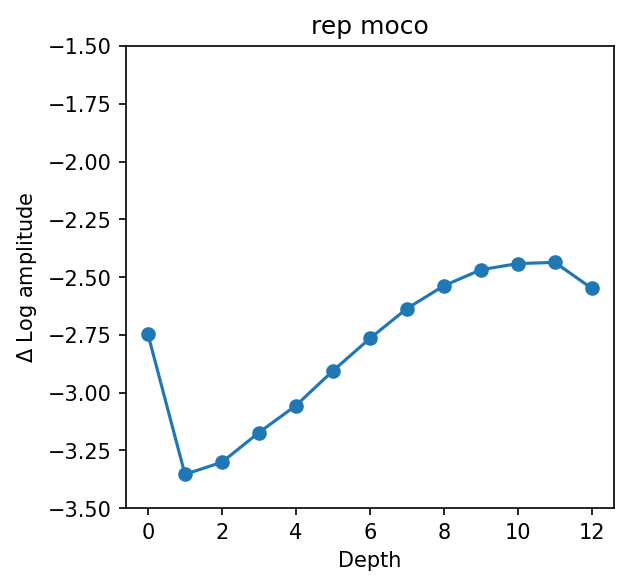

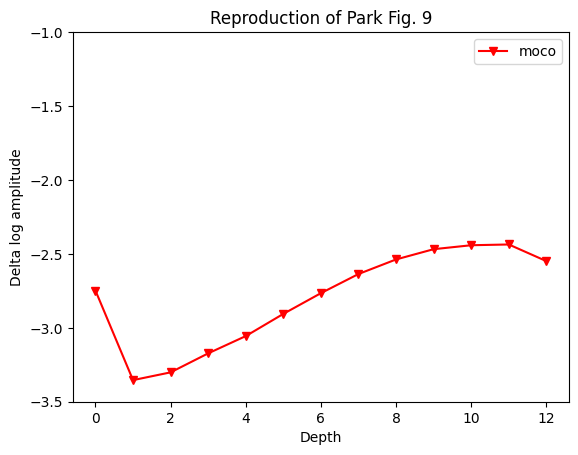

In [5]:
# build off the implementation of https://github.com/xxxnell/how-do-vits-work
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat
from timm.utils import AverageMeter

def fourier(x):
    """2D Fourier transform"""
    f = torch.fft.fft2(x)
    f = f.abs() + 1e-6
    f = f.log()
    return f

def shift(x):
    """shift Fourier transformed feature map"""
    b, c, h, w = x.shape
    return torch.roll(x, shifts=(int(h/2), int(w/2)), dims=(2, 3))

def get_fourier_latents(latents):
    """Fourier transform feature maps"""
    fourier_latents = []
    for latent in latents:  # `latents` is a list of hidden feature maps in latent spaces
        latent = latent.cpu()
        b, n, c = latent.shape
        h, w = int(math.sqrt(n)), int(math.sqrt(n))
        latent = rearrange(latent, "b (h w) c -> b c h w", h=h, w=w)

        latent = fourier(latent)
        latent = shift(latent).mean(dim=(0, 1))
        latent = latent.diag()[int(h/2):]  # only use the half-diagonal components
        latent = latent - latent[0]  # visualize 'relative' log amplitudes
                                     # (i.e., low-freq amp - high freq amp)
        fourier_latents.append(latent)

    return fourier_latents

os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3/Fig9files')
####Instead of the menu bar, perform both options
res = []
for model_option in ["moco"]:
  if model_option == "moco":
      model = model_moco
  elif model_option == "simmim":
      model = model_simmim
  else:
      raise Exception("Invalid option: ", model_option)

  fourier_latents = AverageMeter()
  for i, (xs, ys) in enumerate(dataset_test):
      with torch.no_grad():
          xs = xs.cuda()
          _, zs, _, _ = model(xs)
          zs = zs[:-1]

      latents = [z[:,1:,:] for z in zs]
      _fourier_latents = torch.stack(get_fourier_latents(latents))
      fourier_latents.update(_fourier_latents)

      if i > -1:
          break

  namo = "rep "+model_option
  fig, ax = plt.subplots(1, 1, figsize=(4.2, 4), dpi=150)
  fourier_latents = fourier_latents.avg
  ax.plot(range(13), fourier_latents[:,-1][::2], marker="o")
  res.append(list(fourier_latents[:,-1][::2]))
  ax.set_xlabel("Depth")
  ax.set_ylabel("$\Delta$ Log amplitude")
  ax.set_ylim(top=-1.5, bottom=-3.5)
  ax.set_title(namo)
  fig.savefig(namo+".jpg")
  plt.show()
  plt.close()

plt.plot(range(13), res[0], label="moco", color="red", marker='v')
plt.legend()
plt.title("Reproduction of Park Fig. 9")
plt.ylabel("Delta log amplitude")
plt.xlabel("Depth")
plt.ylim([-3.5,-1])
fig = plt.gcf()
fig.savefig("fig9.jpg")
plt.show()
plt.close()
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA2_2')

The below is from the Self-Attention Analysis-notebook by Park.

Replicate Figure 2 in Park on an image available in Imagenette. There are 8 heads in total, zero-indexed.

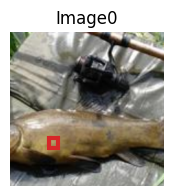

b0h0d1


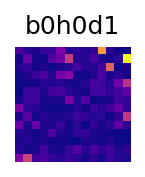

b0h0d4


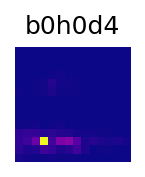

b0h0d11


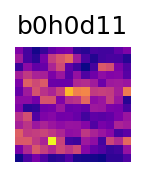

b0h1d1


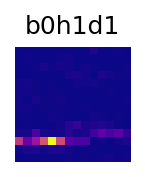

b0h1d4


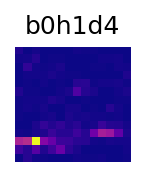

b0h1d11


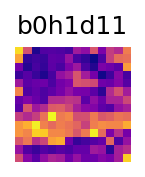

b0h2d1


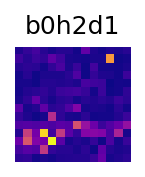

b0h2d4


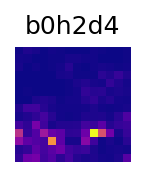

b0h2d11


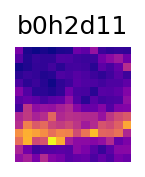

b0h3d1


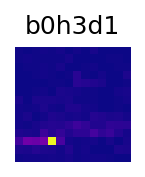

b0h3d4


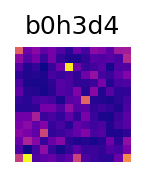

b0h3d11


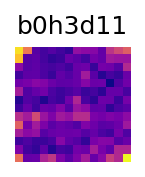

b0h4d1


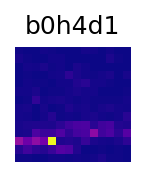

b0h4d4


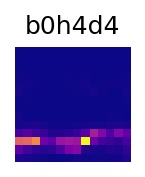

b0h4d11


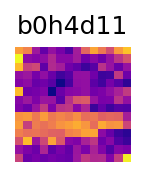

b0h5d1


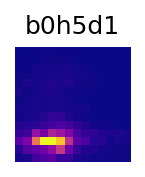

b0h5d4


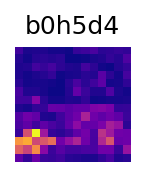

b0h5d11


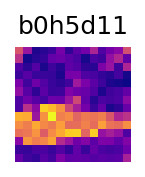

b0h6d1


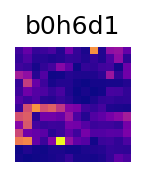

b0h6d4


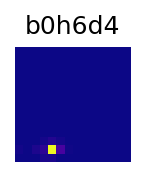

b0h6d11


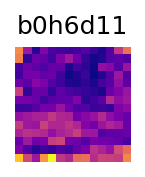

b0h7d1


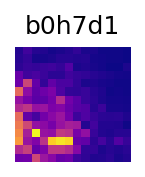

b0h7d4


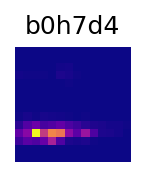

b0h7d11


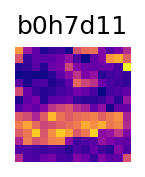

this image has 8 heads 



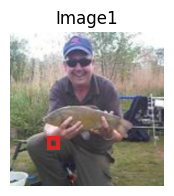

b1h0d1


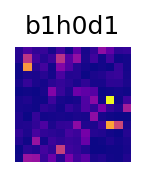

b1h0d4


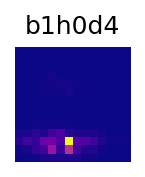

b1h0d11


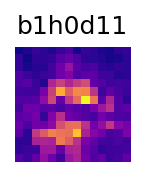

b1h1d1


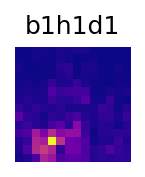

b1h1d4


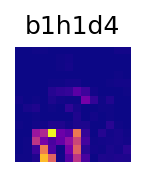

b1h1d11


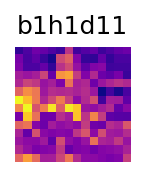

b1h2d1


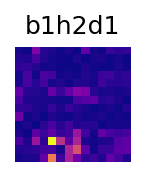

b1h2d4


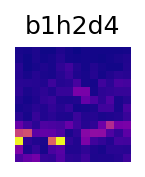

b1h2d11


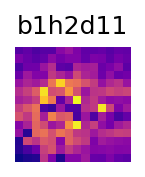

b1h3d1


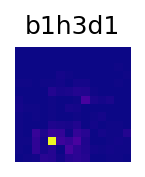

b1h3d4


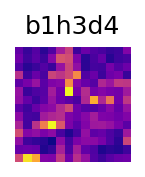

b1h3d11


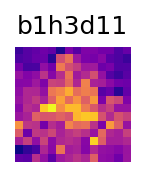

b1h4d1


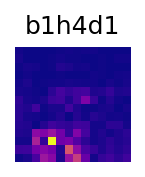

b1h4d4


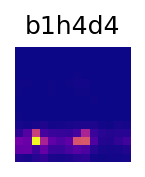

b1h4d11


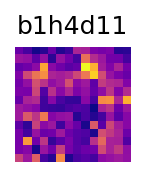

b1h5d1


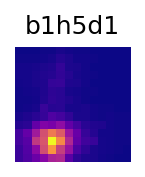

b1h5d4


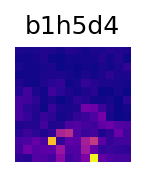

b1h5d11


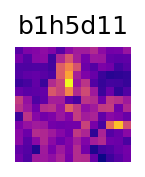

b1h6d1


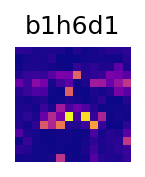

b1h6d4


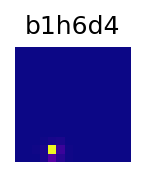

b1h6d11


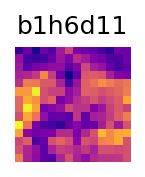

b1h7d1


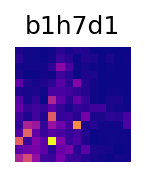

b1h7d4


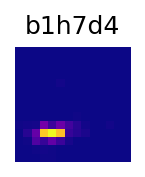

b1h7d11


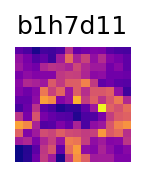

this image has 8 heads 



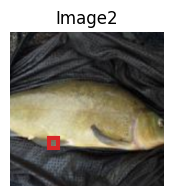

b2h0d1


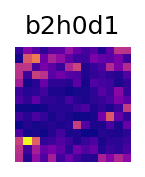

b2h0d4


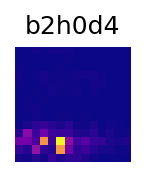

b2h0d11


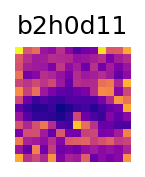

b2h1d1


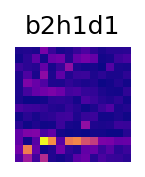

b2h1d4


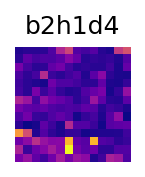

b2h1d11


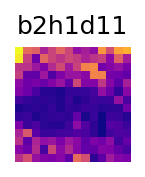

b2h2d1


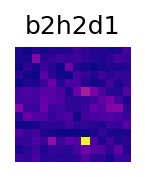

b2h2d4


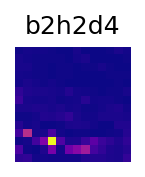

b2h2d11


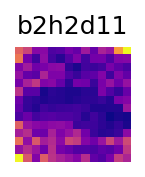

b2h3d1


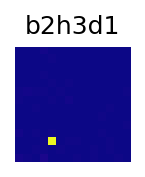

b2h3d4


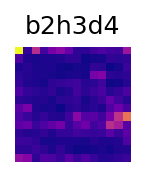

b2h3d11


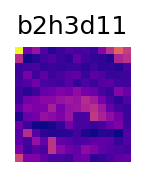

b2h4d1


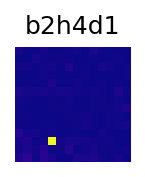

b2h4d4


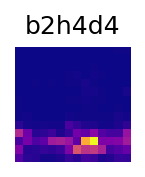

b2h4d11


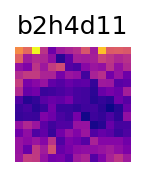

b2h5d1


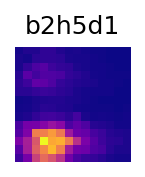

b2h5d4


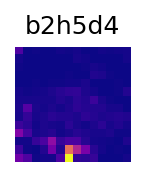

b2h5d11


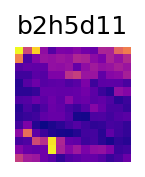

b2h6d1


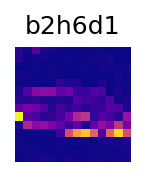

b2h6d4


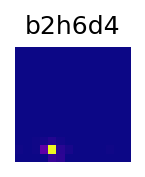

b2h6d11


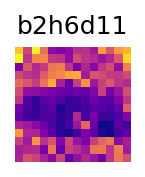

b2h7d1


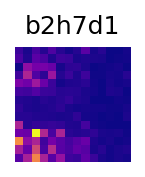

b2h7d4


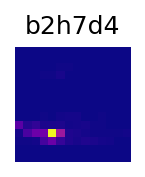

b2h7d11


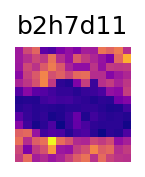

this image has 8 heads 



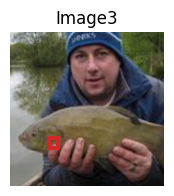

b3h0d1


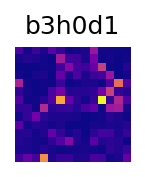

b3h0d4


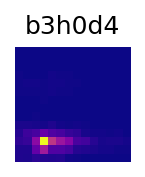

b3h0d11


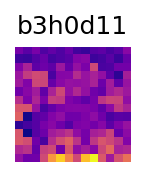

b3h1d1


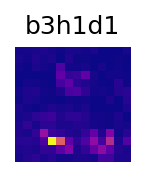

b3h1d4


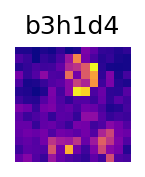

b3h1d11


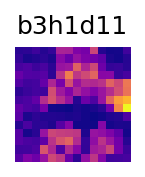

b3h2d1


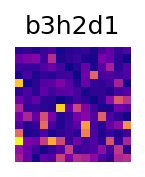

b3h2d4


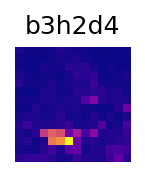

b3h2d11


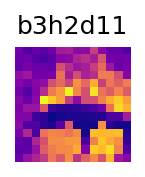

b3h3d1


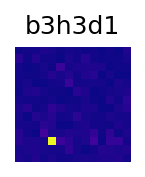

b3h3d4


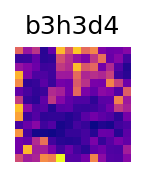

b3h3d11


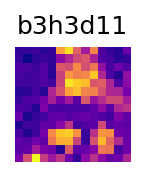

b3h4d1


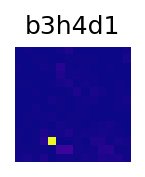

b3h4d4


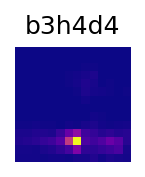

b3h4d11


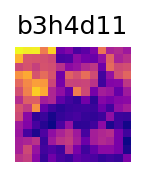

b3h5d1


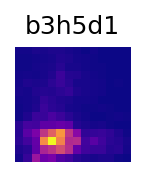

b3h5d4


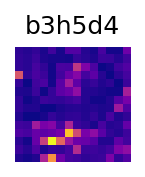

b3h5d11


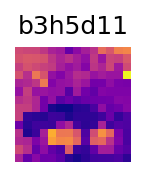

b3h6d1


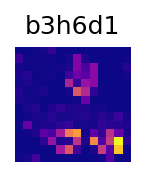

b3h6d4


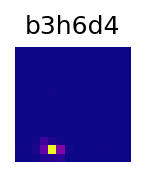

b3h6d11


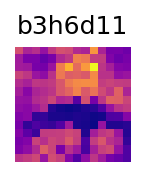

b3h7d1


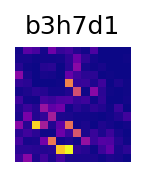

b3h7d4


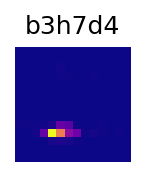

b3h7d11


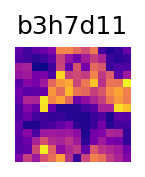

this image has 8 heads 



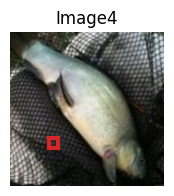

b4h0d1


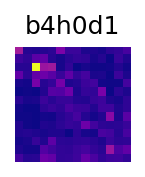

b4h0d4


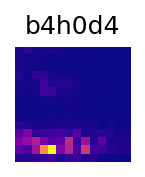

b4h0d11


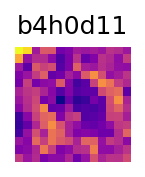

b4h1d1


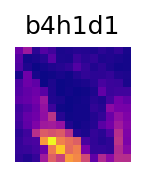

b4h1d4


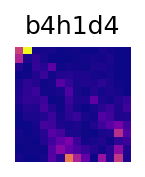

b4h1d11


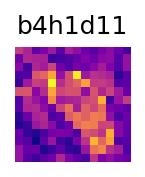

b4h2d1


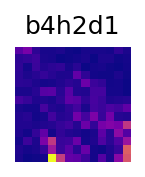

b4h2d4


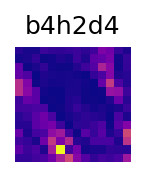

b4h2d11


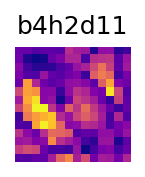

b4h3d1


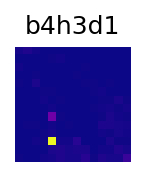

b4h3d4


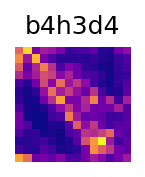

b4h3d11


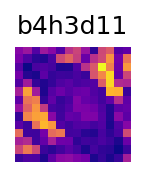

b4h4d1


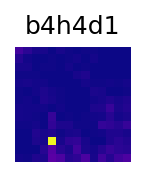

b4h4d4


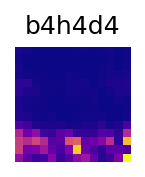

b4h4d11


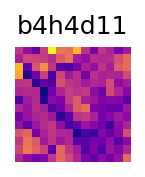

b4h5d1


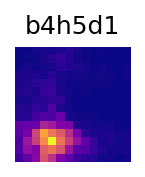

b4h5d4


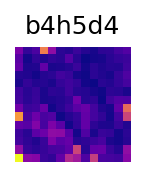

b4h5d11


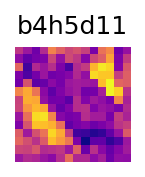

b4h6d1


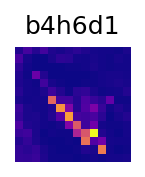

b4h6d4


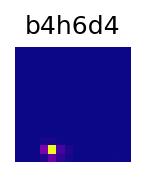

b4h6d11


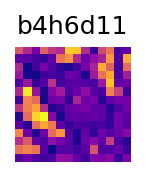

b4h7d1


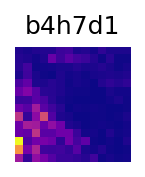

b4h7d4


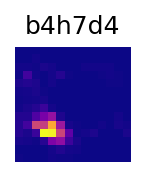

b4h7d11


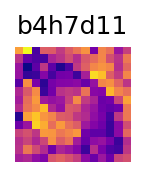

this image has 8 heads 



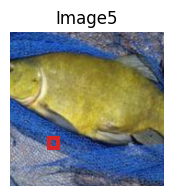

b5h0d1


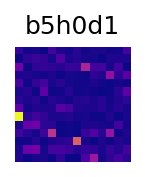

b5h0d4


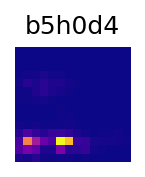

b5h0d11


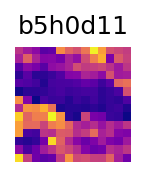

b5h1d1


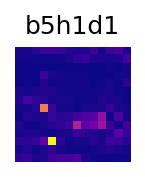

b5h1d4


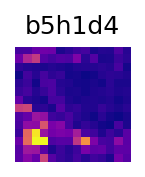

b5h1d11


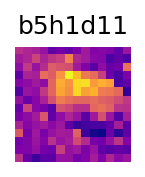

b5h2d1


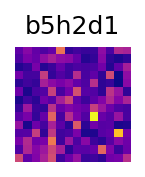

b5h2d4


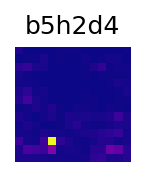

b5h2d11


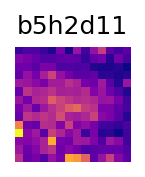

b5h3d1


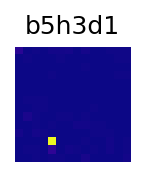

b5h3d4


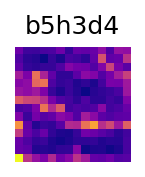

b5h3d11


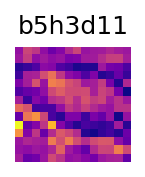

b5h4d1


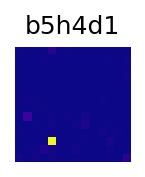

b5h4d4


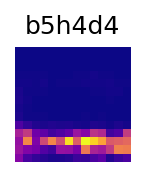

b5h4d11


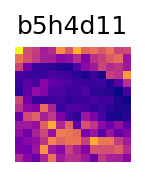

b5h5d1


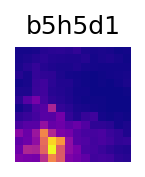

b5h5d4


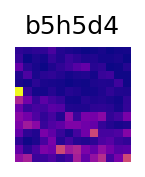

b5h5d11


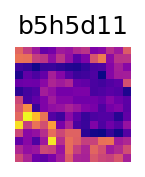

b5h6d1


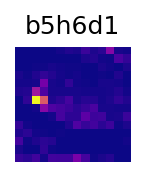

b5h6d4


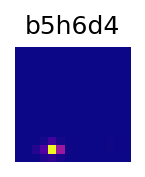

b5h6d11


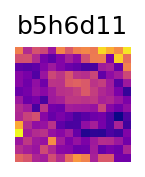

b5h7d1


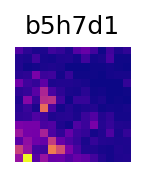

b5h7d4


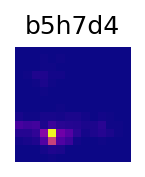

b5h7d11


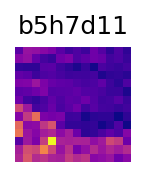

this image has 8 heads 



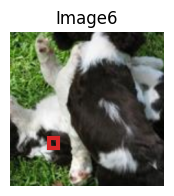

b6h0d1


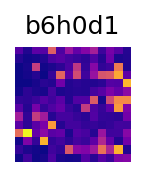

b6h0d4


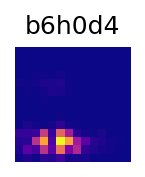

b6h0d11


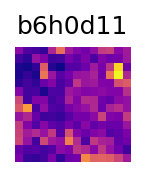

b6h1d1


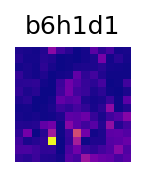

b6h1d4


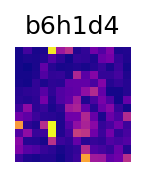

b6h1d11


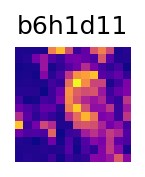

b6h2d1


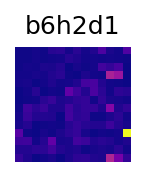

b6h2d4


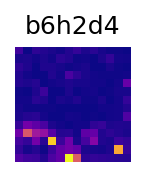

b6h2d11


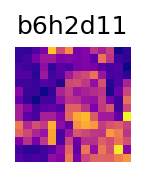

b6h3d1


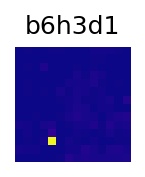

b6h3d4


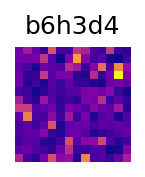

b6h3d11


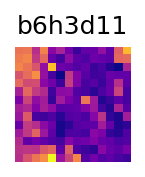

b6h4d1


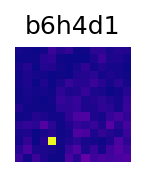

b6h4d4


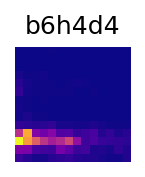

b6h4d11


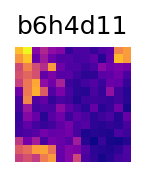

b6h5d1


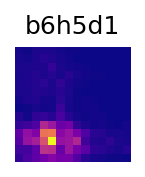

b6h5d4


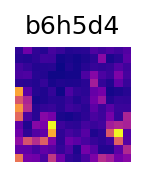

b6h5d11


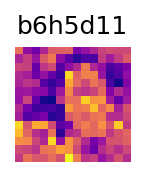

b6h6d1


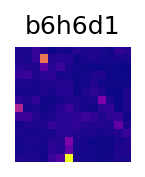

b6h6d4


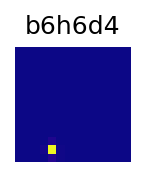

b6h6d11


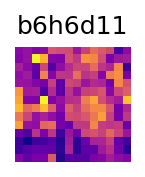

b6h7d1


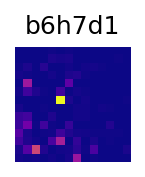

b6h7d4


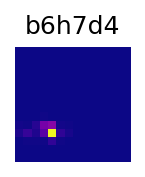

b6h7d11


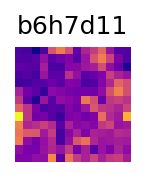

this image has 8 heads 



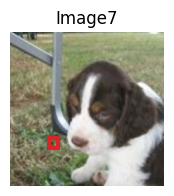

b7h0d1


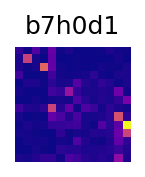

b7h0d4


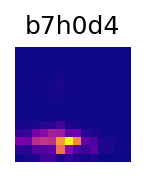

b7h0d11


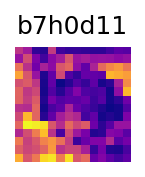

b7h1d1


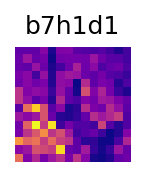

b7h1d4


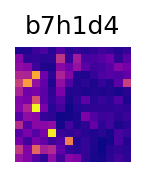

b7h1d11


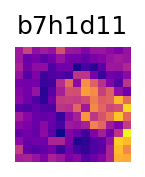

b7h2d1


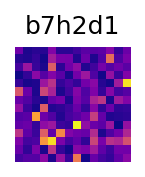

b7h2d4


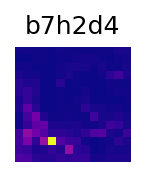

b7h2d11


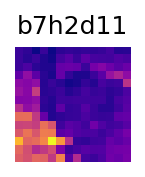

b7h3d1


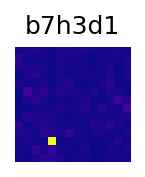

b7h3d4


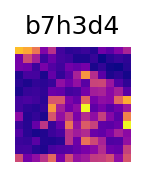

b7h3d11


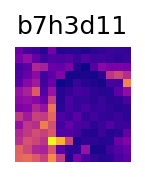

b7h4d1


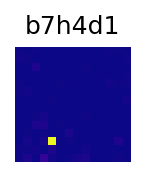

b7h4d4


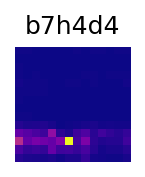

b7h4d11


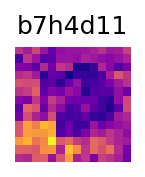

b7h5d1


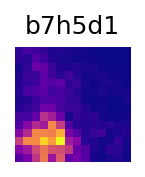

b7h5d4


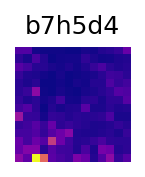

b7h5d11


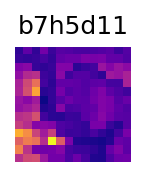

b7h6d1


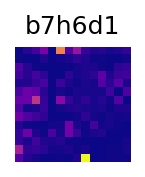

b7h6d4


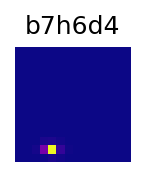

b7h6d11


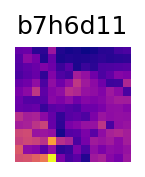

b7h7d1


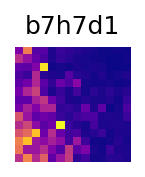

b7h7d4


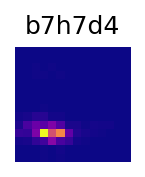

b7h7d11


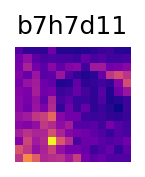

this image has 8 heads 



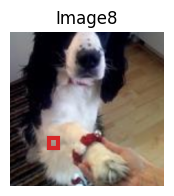

b8h0d1


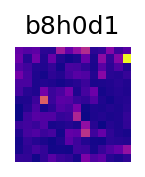

b8h0d4


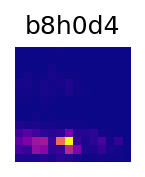

b8h0d11


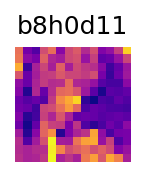

b8h1d1


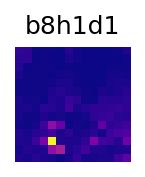

b8h1d4


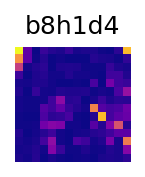

b8h1d11


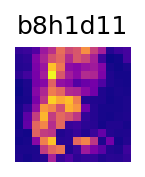

b8h2d1


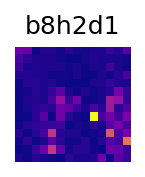

b8h2d4


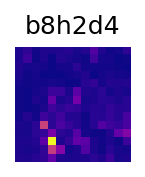

b8h2d11


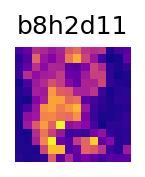

b8h3d1


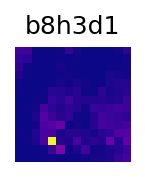

b8h3d4


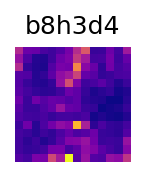

b8h3d11


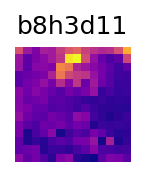

b8h4d1


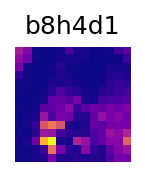

b8h4d4


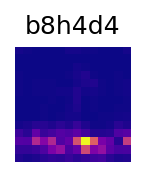

b8h4d11


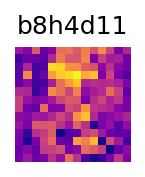

b8h5d1


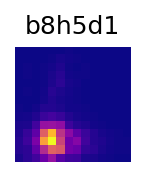

b8h5d4


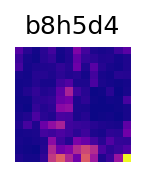

b8h5d11


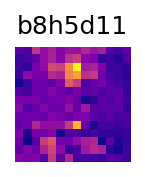

b8h6d1


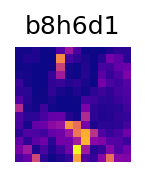

b8h6d4


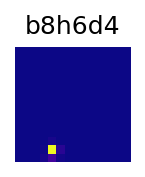

b8h6d11


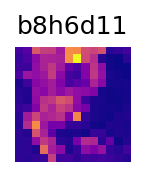

b8h7d1


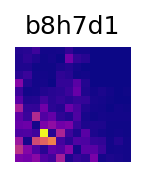

b8h7d4


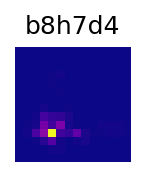

b8h7d11


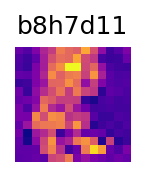

this image has 8 heads 



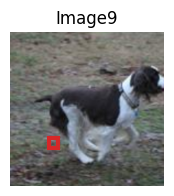

b9h0d1


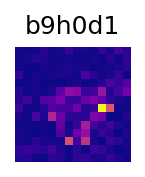

b9h0d4


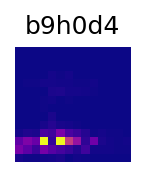

b9h0d11


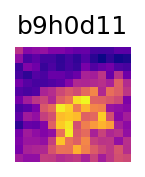

b9h1d1


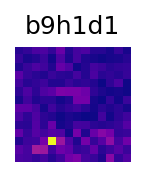

b9h1d4


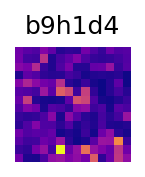

b9h1d11


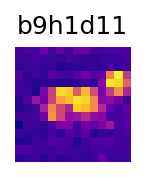

b9h2d1


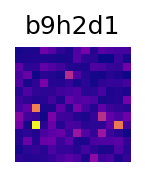

b9h2d4


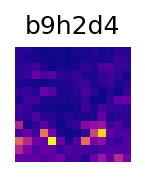

b9h2d11


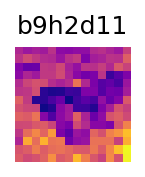

b9h3d1


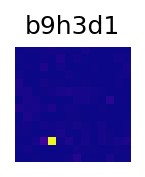

b9h3d4


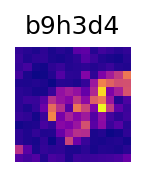

b9h3d11


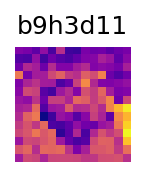

b9h4d1


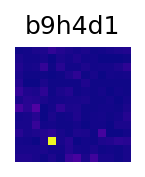

b9h4d4


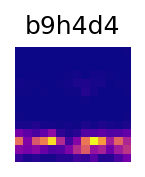

b9h4d11


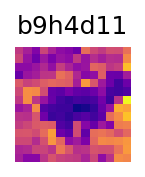

b9h5d1


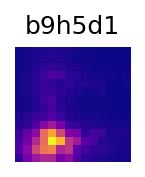

b9h5d4


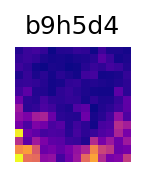

b9h5d11


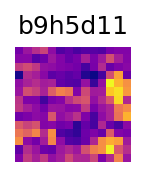

b9h6d1


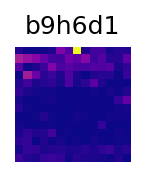

b9h6d4


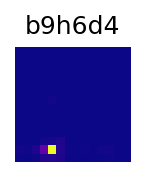

b9h6d11


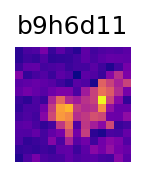

b9h7d1


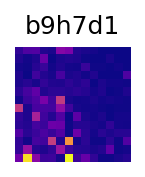

b9h7d4


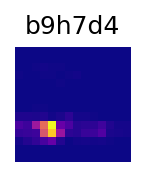

b9h7d11


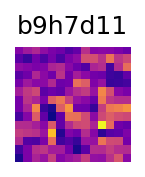

this image has 8 heads 



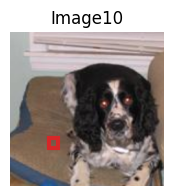

b10h0d1


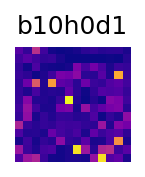

b10h0d4


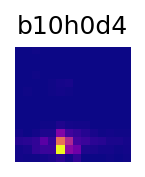

b10h0d11


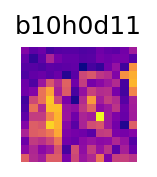

b10h1d1


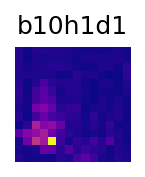

b10h1d4


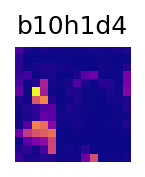

b10h1d11


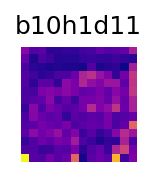

b10h2d1


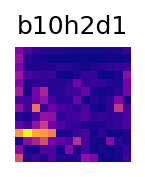

b10h2d4


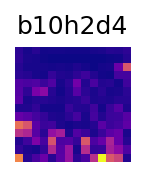

b10h2d11


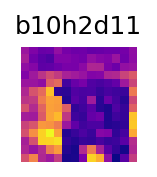

b10h3d1


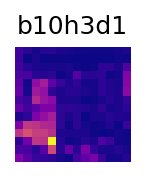

b10h3d4


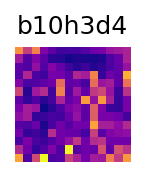

b10h3d11


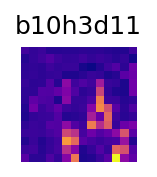

b10h4d1


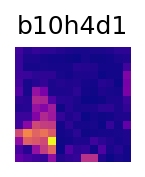

b10h4d4


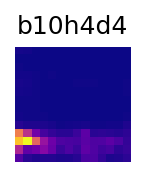

b10h4d11


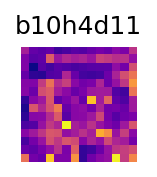

b10h5d1


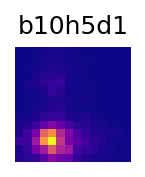

b10h5d4


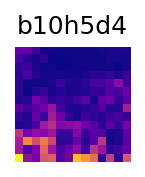

b10h5d11


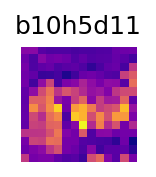

b10h6d1


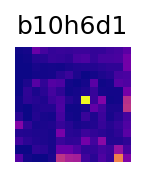

b10h6d4


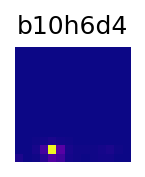

b10h6d11


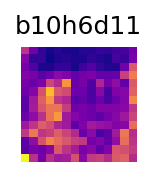

b10h7d1


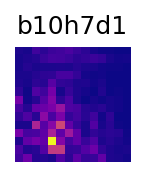

b10h7d4


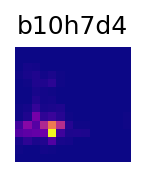

b10h7d11


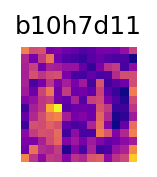

this image has 8 heads 



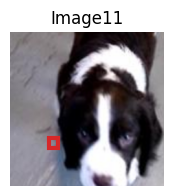

b11h0d1


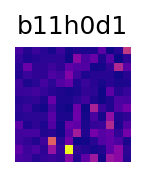

b11h0d4


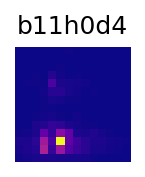

b11h0d11


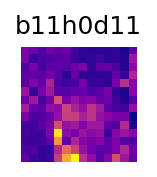

b11h1d1


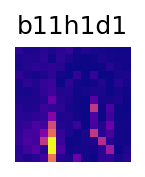

b11h1d4


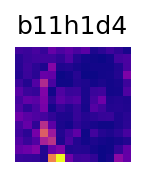

b11h1d11


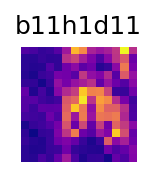

b11h2d1


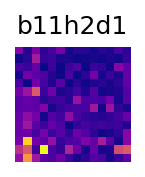

b11h2d4


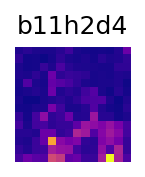

b11h2d11


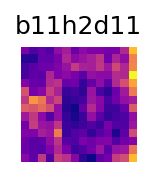

b11h3d1


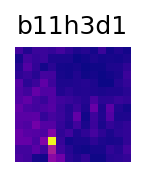

b11h3d4


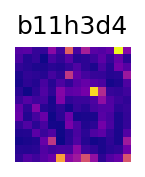

b11h3d11


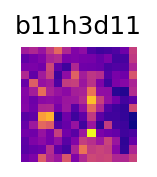

b11h4d1


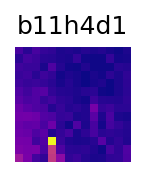

b11h4d4


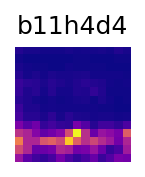

b11h4d11


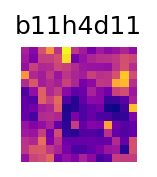

b11h5d1


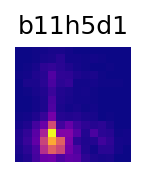

b11h5d4


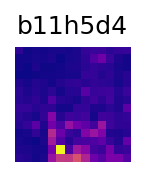

b11h5d11


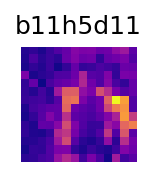

b11h6d1


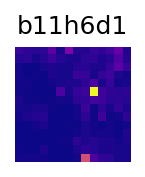

b11h6d4


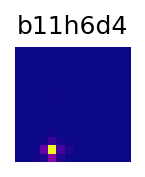

b11h6d11


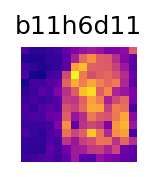

b11h7d1


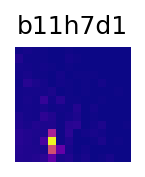

b11h7d4


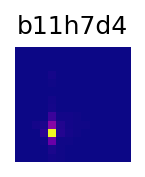

b11h7d11


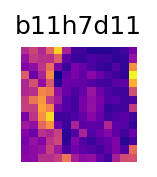

this image has 8 heads 



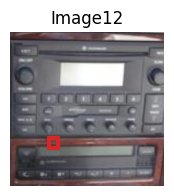

b12h0d1


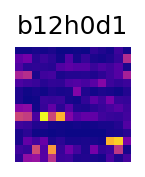

b12h0d4


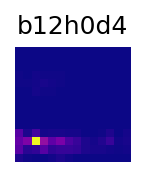

b12h0d11


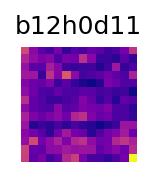

b12h1d1


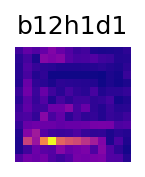

b12h1d4


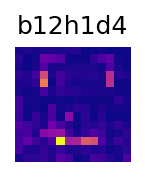

b12h1d11


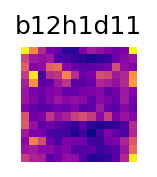

b12h2d1


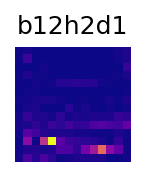

b12h2d4


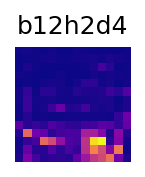

b12h2d11


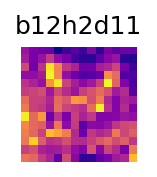

b12h3d1


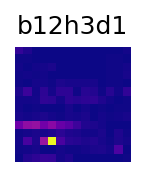

b12h3d4


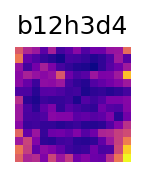

b12h3d11


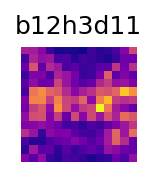

b12h4d1


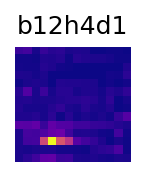

b12h4d4


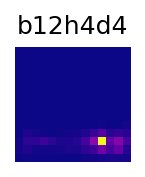

b12h4d11


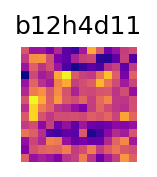

b12h5d1


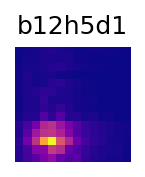

b12h5d4


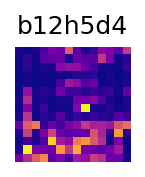

b12h5d11


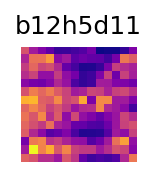

b12h6d1


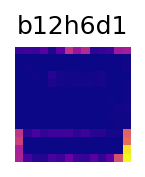

b12h6d4


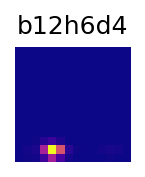

b12h6d11


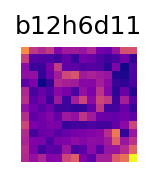

b12h7d1


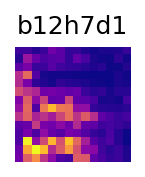

b12h7d4


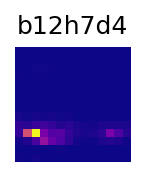

b12h7d11


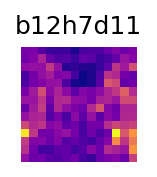

this image has 8 heads 



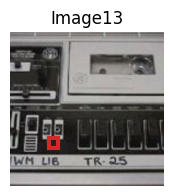

b13h0d1


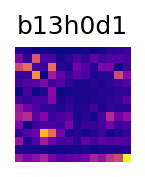

b13h0d4


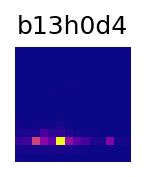

b13h0d11


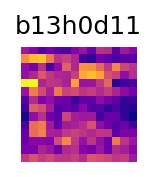

b13h1d1


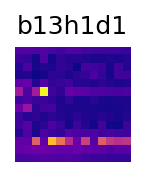

b13h1d4


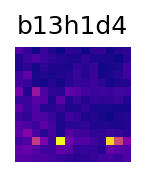

b13h1d11


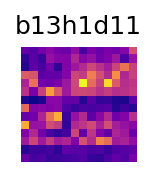

b13h2d1


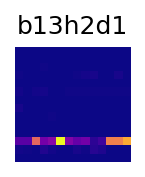

b13h2d4


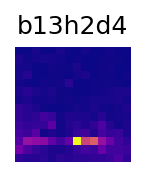

b13h2d11


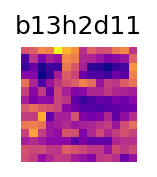

b13h3d1


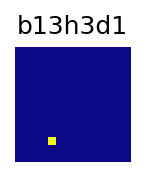

b13h3d4


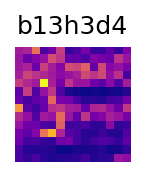

b13h3d11


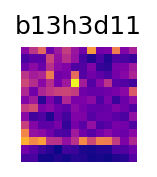

b13h4d1


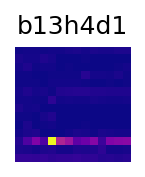

b13h4d4


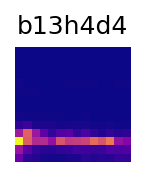

b13h4d11


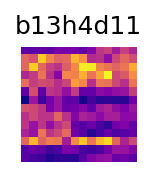

b13h5d1


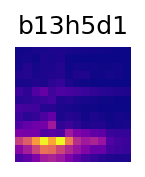

b13h5d4


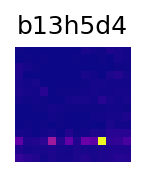

b13h5d11


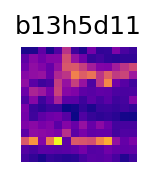

b13h6d1


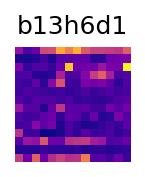

b13h6d4


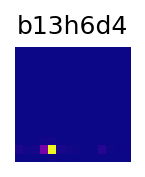

b13h6d11


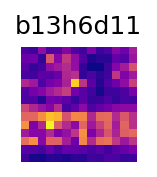

b13h7d1


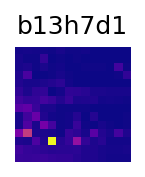

b13h7d4


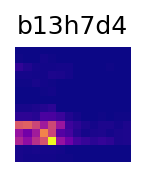

b13h7d11


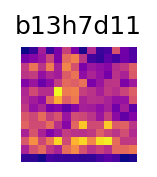

this image has 8 heads 



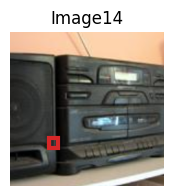

b14h0d1


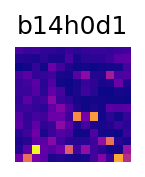

b14h0d4


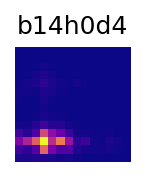

b14h0d11


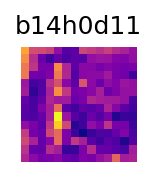

b14h1d1


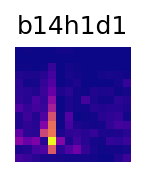

b14h1d4


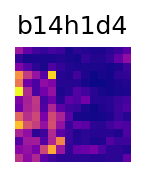

b14h1d11


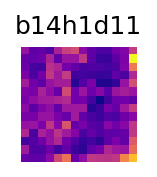

b14h2d1


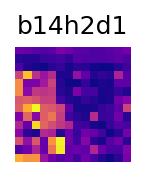

b14h2d4


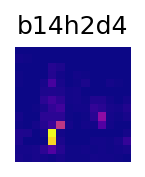

b14h2d11


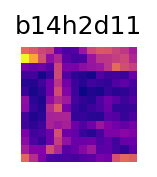

b14h3d1


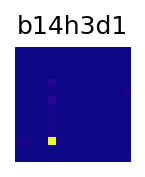

b14h3d4


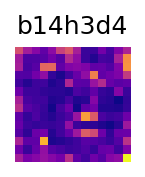

b14h3d11


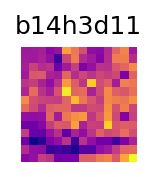

b14h4d1


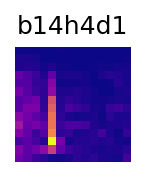

b14h4d4


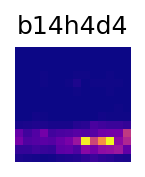

b14h4d11


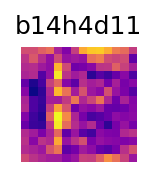

b14h5d1


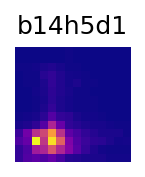

b14h5d4


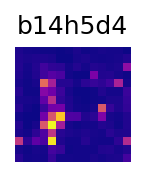

b14h5d11


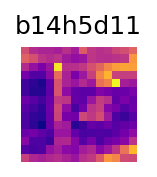

b14h6d1


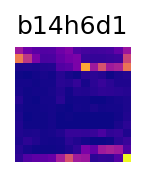

b14h6d4


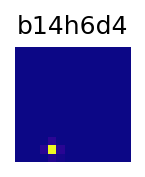

b14h6d11


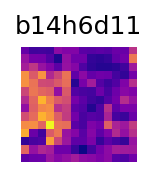

b14h7d1


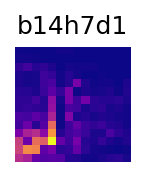

b14h7d4


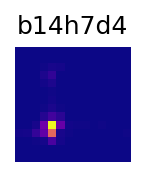

b14h7d11


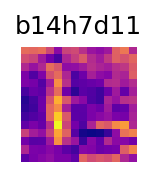

this image has 8 heads 



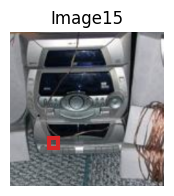

b15h0d1


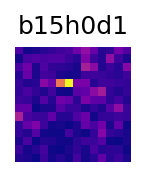

b15h0d4


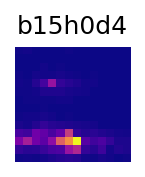

b15h0d11


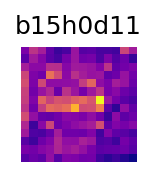

b15h1d1


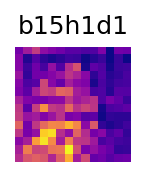

b15h1d4


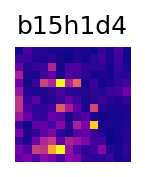

b15h1d11


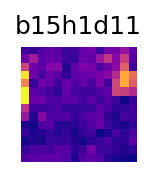

b15h2d1


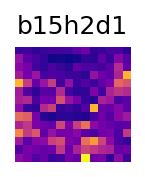

b15h2d4


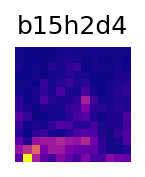

b15h2d11


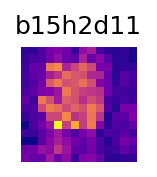

b15h3d1


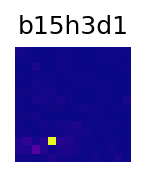

b15h3d4


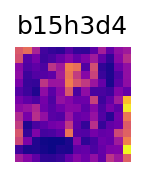

b15h3d11


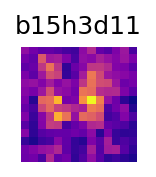

b15h4d1


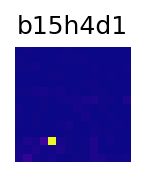

b15h4d4


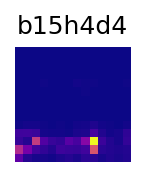

b15h4d11


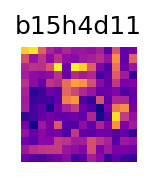

b15h5d1


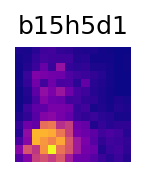

b15h5d4


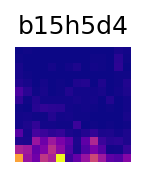

b15h5d11


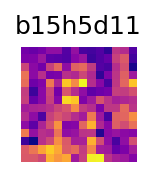

b15h6d1


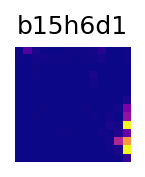

b15h6d4


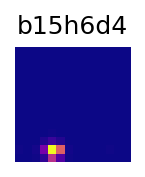

b15h6d11


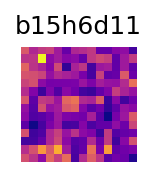

b15h7d1


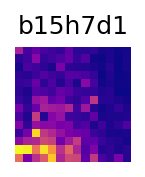

b15h7d4


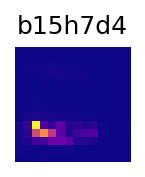

b15h7d11


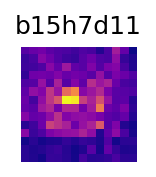

this image has 8 heads 

there are 16 images in the dataset


In [ ]:
def mark_token(namo, ax, xs, batch, i, j, color='tab:red'):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=100)
    import matplotlib.patches as patches
    from einops import rearrange, reduce, repeat
    from utils import restore

    ax.imshow(rearrange(restore(xs.cpu())[batch], 'c h w -> h w c'))
    ax.set_axis_off()

    # create a rectangle patch to visualize the query token
    rect = patches.Rectangle((14 * i, 14 * j), 14, 14, linewidth=3, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    plt.title(namo)
    ##plt.show()
    fig.savefig(namo+".jpg")
    plt.close()

def visualize_attn(fig, ax, namo, attns, batch, i, j, depth, head):
    """
    ax: matplotlib axes
    xs: batch
    batch, i, j: batch coords
    attns, depth, head:
    """
    attn_list = [list(attn[batch].cpu()) if attn is not None else None for attn in attns]
    attn = torch.stack(attn_list[depth])
    attn = attn[head]  # take head-th head
    attn = attn[1:,1:]  # drop cls token
    attn = attn / attn.sum(dim=-1, keepdim=True)  # normalize
    attn = attn[j * 14 + i]
    attn = attn.reshape([14, 14])
    fig, ax = plt.subplots(1, 1, figsize=(1, 1), dpi=150)
    plt.title(namo)
    ax.imshow(attn, cmap="plasma", )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()
    fig.savefig(namo+".jpg")
    ##plt.show()
    plt.close()
    return attn

####This visualization demonstrates that the self-attentions of CL (MoCo) generally captures global relationships and objects. However, they tend to produce homogeneous attention maps for all query tokens and heads, particularly when compared to MIM. In contrast, the self-attentions of MIM (SimMIM) primarily focus on localized areas.

os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3/blhfiles')
for filename in os.listdir():
  os.remove(filename)
class Image:
    def __init__(self):
      self.heads = []

    def report(self):
      print(f"this image has {str(len(self.heads))} heads", end=" ")

class Head:
    def __init__(self):
      self.layers = []

    def report(self):
      print(f"this head has {str(len(self.layers))} layers", end = " ")

images = []

for batch in range(16):
  img = Image()
  tuplo = (4,11)
  coord_x, coord_y = tuplo
  token_name = "Image"+str(batch)
  mark_token(token_name, ax, xs, batch=batch, i=coord_x, j=coord_y, color='tab:red')
  for head in range(8):
    hd = Head()
    model = model_moco
    for d_index in range (3):
      depth = [1, 4, 11][d_index]
      namo = "b"+str(batch)+"h"+str(head)+"d"+str(depth)
      print(namo)
      xs, ys = next(iter(dataset_test))
      with torch.no_grad():
          xs = xs.cuda()
          _, _, attns, _ = model(xs)
      data = visualize_attn(fig, ax, namo, attns, batch=batch, i=coord_x, j=coord_y, depth=depth, head=head)
      ##print(type(data), end=" ")
      ##print(data.shape, end=" ")
      hd.layers.append(data)
    ##hd.report()
    img.heads.append(hd)
  img.report()
  images.append(img)
  print("\n")
print(f"there are {str(len(images))} images in the dataset")
with open("images.pickle", "wb") as f:
  pickle.dump(images, f)
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3')

In [12]:
elem = images[0].heads[0].layers[0]

To compare by head, perform the above but for all 8 heads, save figures to relevant subdirectory.

In [13]:
print(type(elem))
print(elem.shape)
print(elem)

<class 'torch.Tensor'>
torch.Size([14, 14])
tensor([[8.8268e-03, 2.7813e-03, 2.0250e-03, 5.1461e-03, 4.5386e-03, 1.6553e-02,
         2.8031e-03, 4.4777e-03, 2.2956e-03, 4.2134e-03, 5.0001e-02, 3.3832e-03,
         5.1889e-04, 4.5158e-04],
        [8.8967e-04, 1.2860e-02, 7.5348e-04, 3.9194e-04, 8.8592e-03, 1.4083e-02,
         3.0590e-02, 3.1133e-03, 2.7214e-03, 7.5472e-03, 2.1461e-03, 1.0125e-03,
         3.4449e-03, 6.4976e-02],
        [2.5904e-03, 4.6751e-03, 6.2208e-04, 1.8643e-03, 4.1257e-04, 1.8833e-03,
         3.1642e-03, 7.5701e-03, 2.9897e-03, 2.3901e-03, 6.6846e-03, 3.8899e-02,
         6.5580e-04, 1.5818e-03],
        [3.6583e-04, 2.3888e-03, 4.9248e-03, 8.3400e-03, 2.8468e-03, 1.4746e-02,
         1.8154e-02, 7.4071e-04, 3.9840e-04, 1.8766e-03, 8.3947e-03, 1.3381e-03,
         3.1063e-03, 9.2239e-04],
        [9.9035e-05, 3.0320e-04, 8.0410e-04, 2.6923e-03, 2.4784e-03, 2.8626e-03,
         1.1274e-03, 5.6516e-04, 2.9893e-03, 7.9569e-03, 6.0690e-03, 2.7920e-03,
         1

In [16]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATDL/HA3/blhfiles')
with open("images.pickle", "rb") as f:
  newdata = pickle.load(f)

In [18]:
newelem = newdata[0].heads[0].layers[0]
print(newelem)


tensor([[8.8268e-03, 2.7813e-03, 2.0250e-03, 5.1461e-03, 4.5386e-03, 1.6553e-02,
         2.8031e-03, 4.4777e-03, 2.2956e-03, 4.2134e-03, 5.0001e-02, 3.3832e-03,
         5.1889e-04, 4.5158e-04],
        [8.8967e-04, 1.2860e-02, 7.5348e-04, 3.9194e-04, 8.8592e-03, 1.4083e-02,
         3.0590e-02, 3.1133e-03, 2.7214e-03, 7.5472e-03, 2.1461e-03, 1.0125e-03,
         3.4449e-03, 6.4976e-02],
        [2.5904e-03, 4.6751e-03, 6.2208e-04, 1.8643e-03, 4.1257e-04, 1.8833e-03,
         3.1642e-03, 7.5701e-03, 2.9897e-03, 2.3901e-03, 6.6846e-03, 3.8899e-02,
         6.5580e-04, 1.5818e-03],
        [3.6583e-04, 2.3888e-03, 4.9248e-03, 8.3400e-03, 2.8468e-03, 1.4746e-02,
         1.8154e-02, 7.4071e-04, 3.9840e-04, 1.8766e-03, 8.3947e-03, 1.3381e-03,
         3.1063e-03, 9.2239e-04],
        [9.9035e-05, 3.0320e-04, 8.0410e-04, 2.6923e-03, 2.4784e-03, 2.8626e-03,
         1.1274e-03, 5.6516e-04, 2.9893e-03, 7.9569e-03, 6.0690e-03, 2.7920e-03,
         1.3877e-02, 2.8496e-02],
        [1.3216e-04,